### Binary Classification Model for Kaggle Tabular Playground Series November 2021 Using XGBoost
### David Lowe
### December 7, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground November 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The data is synthetically generated by a GAN trained on a real-world dataset used to identify spam emails via various extracted features from the email. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the preliminary XGBoost model achieved an ROC/AUC benchmark of 0.7185. After a series of tuning trials, the refined XGBoost model processed the training dataset with a final score of 0.7455. When we applied the last model to Kaggle's test dataset, the model achieved a ROC/AUC score of 0.7385.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 November Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-nov-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-nov-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Tune Models
5. Finalize Model and Make Predictions

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Dec  2 16:16:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'roc_auc'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021nov/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id        f0       f1        f2  ...      f97       f98       f99  target
0   0  0.106643  3.59437  132.8040  ...  1.97877  0.085974  0.240496       0
1   1  0.125021  1.67336   76.5336  ...  2.57786 -0.020877  0.024719       0
2   2  0.036330  1.49747  233.5460  ...  2.14112  0.124464  0.148209       0
3   3 -0.014077  0.24600  779.9670  ...  1.96860  0.040017  0.044873       0
4   4 -0.003259  3.71542  156.1280  ...  1.07481 -0.012819  0.072798       1

[5 rows x 102 columns]


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 102 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   f0      float64
 2   f1      float64
 3   f2      float64
 4   f3      float64
 5   f4      float64
 6   f5      float64
 7   f6      float64
 8   f7      float64
 9   f8      float64
 10  f9      float64
 11  f10     float64
 12  f11     float64
 13  f12     float64
 14  f13     float64
 15  f14     float64
 16  f15     float64
 17  f16     float64
 18  f17     float64
 19  f18     float64
 20  f19     float64
 21  f20     float64
 22  f21     float64
 23  f22     float64
 24  f23     float64
 25  f24     float64
 26  f25     float64
 27  f26     float64
 28  f27     float64
 29  f28     float64
 30  f29     float64
 31  f30     float64
 32  f31     float64
 33  f32     float64
 34  f33     float64
 35  f34     float64
 36  f35     float64
 37  f36     float64
 38  f37     float64
 39  f38     float64
 40  f

In [12]:
print(df_dataset_import.describe())

                  id             f0  ...            f99         target
count  600000.000000  600000.000000  ...  600000.000000  600000.000000
mean   299999.500000       0.306508  ...       0.123048       0.506010
std    173205.225094       0.522450  ...       0.264896       0.499964
min         0.000000      -3.797450  ...      -2.783380       0.000000
25%    149999.750000       0.026222  ...       0.018105       0.000000
50%    299999.500000       0.097788  ...       0.058471       1.000000
75%    449999.250000       0.397184  ...       0.104872       1.000000
max    599999.000000       8.781500  ...       5.988110       1.000000

[8 rows x 102 columns]


In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
f0        0
f1        0
f2        0
f3        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 102, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)


# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

         f0       f1        f2       f3  ...      f97       f98       f99  target
0  0.106643  3.59437  132.8040  3.18428  ...  1.97877  0.085974  0.240496       0
1  0.125021  1.67336   76.5336  3.37825  ...  2.57786 -0.020877  0.024719       0
2  0.036330  1.49747  233.5460  2.19435  ...  2.14112  0.124464  0.148209       0
3 -0.014077  0.24600  779.9670  1.89064  ...  1.96860  0.040017  0.044873       0
4 -0.003259  3.71542  156.1280  2.14772  ...  1.07481 -0.012819  0.072798       1

[5 rows x 101 columns]


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 101 columns):
 #   Column  Dtype  
---  ------  -----  
 0   f0      float64
 1   f1      float64
 2   f2      float64
 3   f3      float64
 4   f4      float64
 5   f5      float64
 6   f6      float64
 7   f7      float64
 8   f8      float64
 9   f9      float64
 10  f10     float64
 11  f11     float64
 12  f12     float64
 13  f13     float64
 14  f14     float64
 15  f15     float64
 16  f16     float64
 17  f17     float64
 18  f18     float64
 19  f19     float64
 20  f20     float64
 21  f21     float64
 22  f22     float64
 23  f23     float64
 24  f24     float64
 25  f25     float64
 26  f26     float64
 27  f27     float64
 28  f28     float64
 29  f29     float64
 30  f30     float64
 31  f31     float64
 32  f32     float64
 33  f33     float64
 34  f34     float64
 35  f35     float64
 36  f36     float64
 37  f37     float64
 38  f38     float64
 39  f39     float64
 40  f

In [16]:
print(df_dataset_import.describe())

                  f0             f1  ...            f99         target
count  600000.000000  600000.000000  ...  600000.000000  600000.000000
mean        0.306508       2.497590  ...       0.123048       0.506010
std         0.522450       1.554018  ...       0.264896       0.499964
min        -3.797450      -1.223960  ...      -2.783380       0.000000
25%         0.026222       1.186238  ...       0.018105       0.000000
50%         0.097788       2.516500  ...       0.058471       1.000000
75%         0.397184       3.787630  ...       0.104872       1.000000
max         8.781500       6.226720  ...       5.988110       1.000000

[8 rows x 101 columns]


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 101, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (600000, 101) df_features_train.shape: (600000, 100) df_target_train.shape: (600000,)


### 1.f) Set up the parameters for data visualization

In [19]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [20]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [21]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

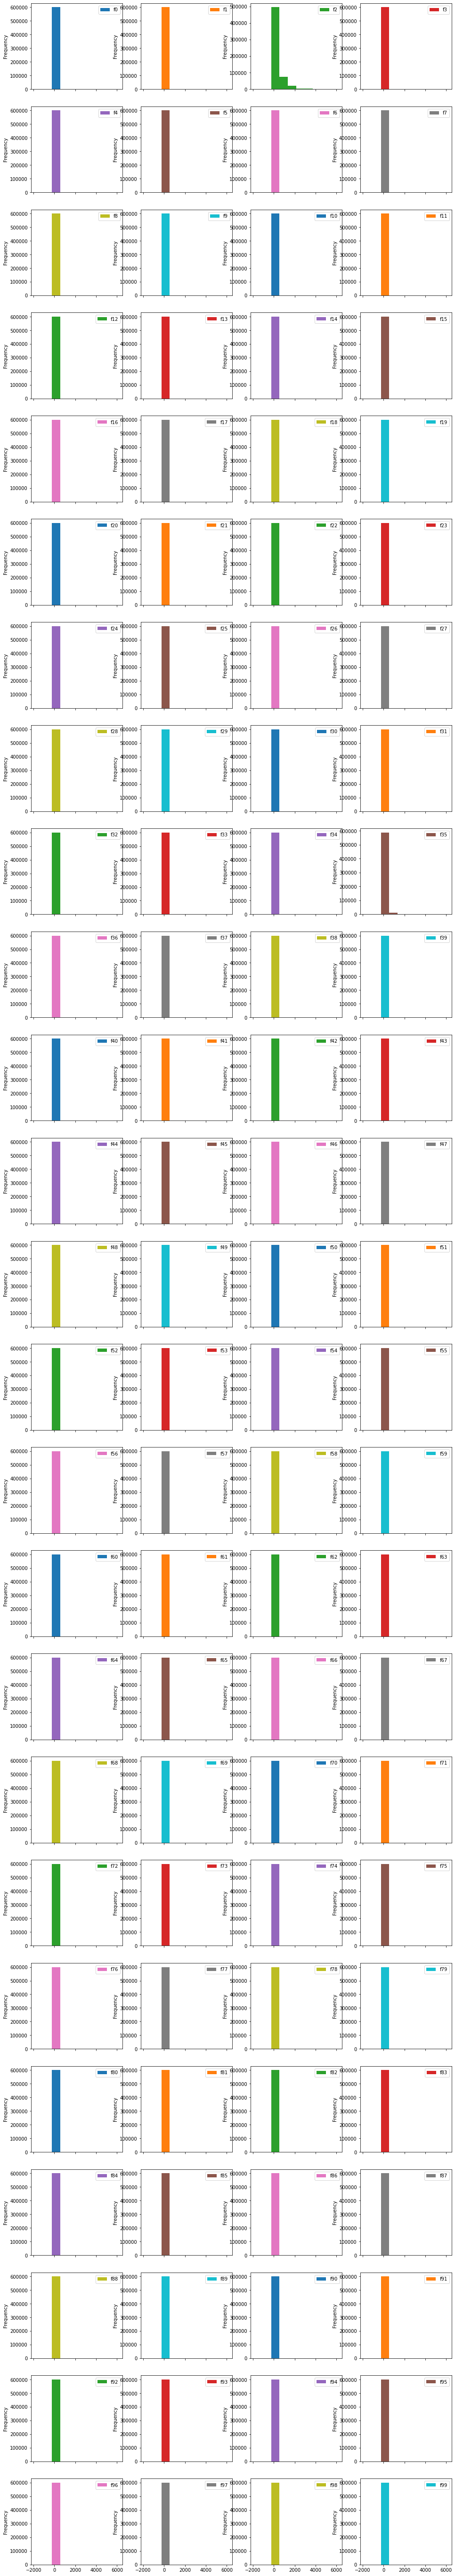

In [22]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

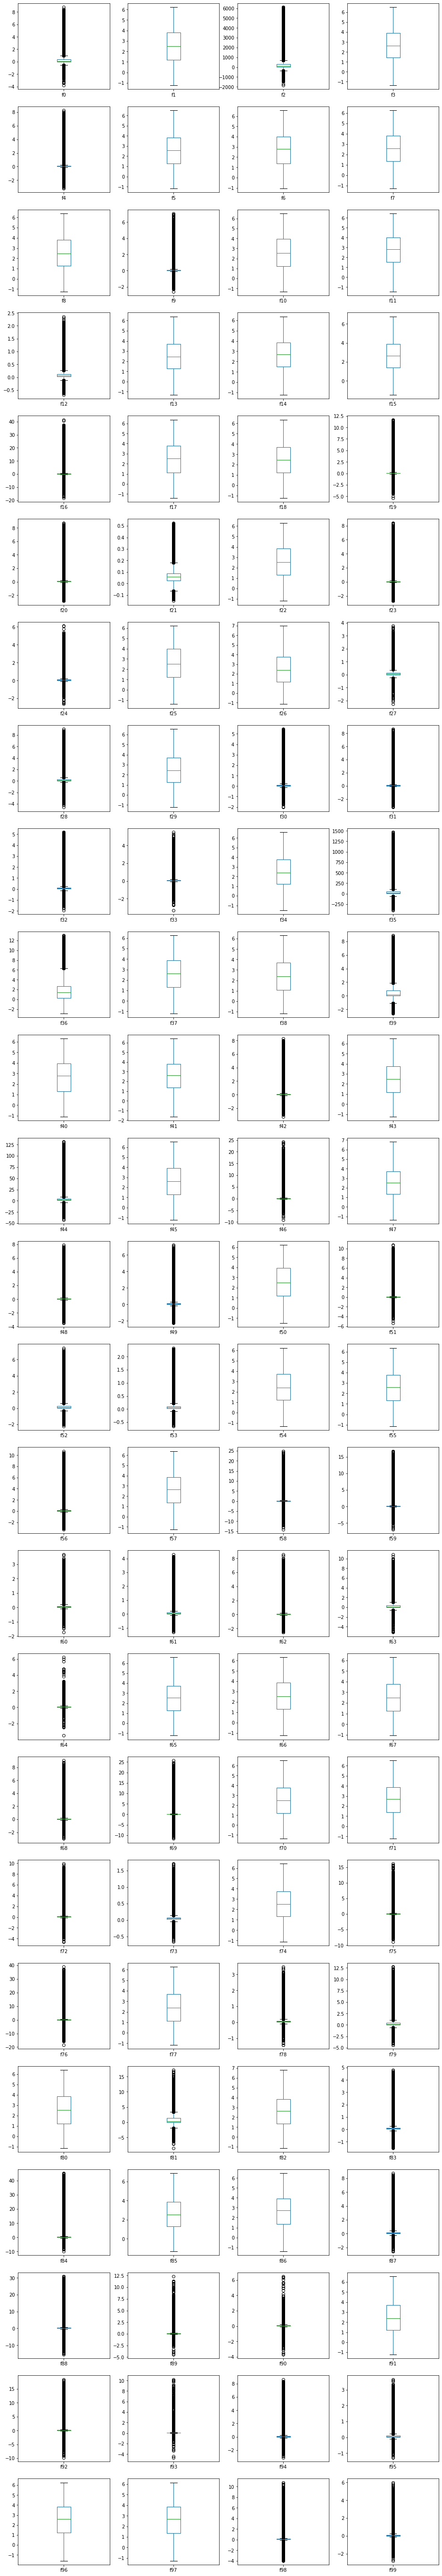

In [23]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [24]:
# # Correlation matrix
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111)
# correlations = df_features_train.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [27]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [28]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 100
Number of categorical columns: 0
Total number of columns in the feature dataframe: 100


In [29]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (600000, 100) to array_features_train.shape: (600000, 100)


### 3.c) Training Data Balancing

In [30]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [31]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [32]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (600000, 100) array_target_train.shape: (600000,)


In [33]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [34]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [35]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = [('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist'))]

In [36]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.718517 (0.001039)
XGBClassifier(random_state=888, tree_method='gpu_hist')
Model training time: 0:00:07.374995 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.4s finished


### 4.b) Algorithm Tuning

In [37]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [38]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 1001, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best: 0.745048 using {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 1000}
0.718517 (0.001039) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.731870 (0.001210) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.737445 (0.001133) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.740414 (0.001155) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.742200 (0.001180) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.743308 (0.001241) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600}
0.744061 (0.001255) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 700}
0.744502 (0.001302) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 800}
0.744806 (0.001277) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 900}
0.744980 (0.001286) with: {'max_depth': 3, 'min_child_weight': 1, 'n_est

In [39]:
BEST_N_ESTIMATORS = 1000
BEST_MAX_DEPTH = 3
BEST_MIN_CHILD_WEIGHT = 2

In [40]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]), colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 0.745596 using {'colsample_bytree': 0.9, 'subsample': 0.8}
0.745421 (0.001278) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.745523 (0.001441) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.745502 (0.001265) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.745099 (0.001166) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.745444 (0.001288) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.745527 (0.001454) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.745513 (0.001296) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.745129 (0.001382) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.745587 (0.001278) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.745596 (0.001267) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.745270 (0.001138) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.745054 (0.001244) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.745409 (0.001102) with: {'colsam

In [41]:
BEST_COLSAMPLE_BYTREE = 0.9
BEST_SUBSAMPLE = 0.8

### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


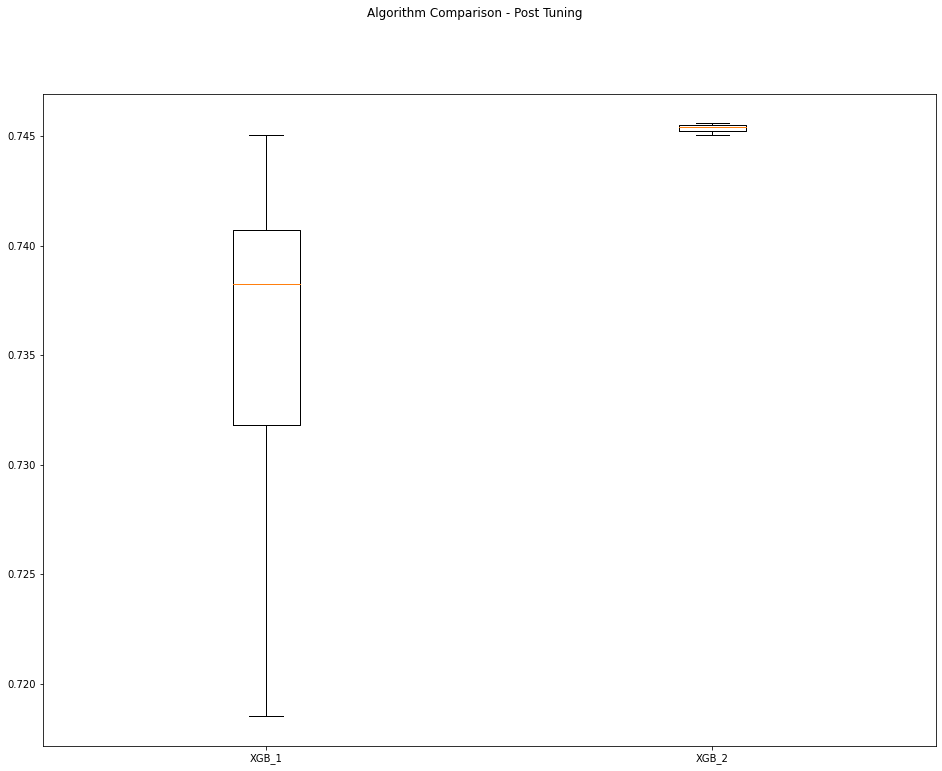

In [42]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [43]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [44]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [45]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(colsample_bytree=0.9, min_child_weight=2, n_estimators=1000,
              random_state=888, subsample=0.8, tree_method='gpu_hist')


### 6.b) Load Test Dataset and Prepare the Submission File

In [46]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021nov/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id        f0        f1       f2  ...       f96       f97       f98       f99
0  600000  0.003229  4.838660  585.529  ...  0.290343  1.898200  0.131533  0.012047
1  600001  0.008602  0.505536 -100.099  ... -0.392923  3.689640  0.047418  0.120015
2  600002  1.461000  2.437260 -112.964  ...  4.054650  3.330670  0.108843  0.064687
3  600003  0.140556  3.085610  179.451  ...  2.696580 -0.533491  0.052524  0.011058
4  600004  0.128876  5.199760  107.466  ...  1.110710  3.584470  0.145319 -0.050393

[5 rows x 101 columns]


In [47]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  600000
1  600001
2  600002
3  600003
4  600004


In [48]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

         f0        f1       f2  ...       f97       f98       f99
0  0.003229  4.838660  585.529  ...  1.898200  0.131533  0.012047
1  0.008602  0.505536 -100.099  ...  3.689640  0.047418  0.120015
2  1.461000  2.437260 -112.964  ...  3.330670  0.108843  0.064687
3  0.140556  3.085610  179.451  ... -0.533491  0.052524  0.011058
4  0.128876  5.199760  107.466  ...  3.584470  0.145319 -0.050393

[5 rows x 100 columns]


In [49]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (540000, 100) to array_features_test.shape: (540000, 100)


In [50]:
# Make batched predictions
test_predictions = final_model.predict_proba(array_features_test)[:,1]
print(test_predictions)

[0.658917   0.57119805 0.8039226  ... 0.5537736  0.64097035 0.60337275]


In [51]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

       id    target
0  600000  0.658917
1  600001  0.571198
2  600002  0.803923
3  600003  0.493003
4  600004  0.481354


In [52]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211202-1716.csv


In [53]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [54]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:59:21.037260
